In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])#这一步是读取图片
    labels = np.array(F['ans'])#这一步是读取图片的标签
    
images = images.astype(np.float32)#这一步是将图片转为float32类型   

labels = utils.to_categorical(labels, 10)#这一步是使用one-hot编码，一个10个类
labels = labels.astype(np.float32)#这一步是图片将图片的标签转为float32类型

In [3]:
(images, labels) = shuffle(images, labels)#这一步是打乱图片和其标签的排列顺序

In [4]:
#classes是类对应的英文名字，是否正确对应未检查。
classes = ['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies','Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies','Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']
class_labels = {classes:i for classes, i in enumerate(classes)}#生成类别名字到标号的对应关系，是否正确对应未检查。
print(class_labels)

{0: 'Disturbed Galaxies', 1: 'Merging Galaxies', 2: 'Round Smooth Galaxies', 3: 'In-between Round Smooth Galaxies', 4: 'Cigar Shaped Smooth Galaxies', 5: 'Barred Spiral Galaxies', 6: 'Unbarred Tight Spiral Galaxies', 7: 'Unbarred Loose Spiral Galaxies', 8: 'Edge-on Galaxies without Bulge', 9: 'Edge-on Galaxies with Bulge'}


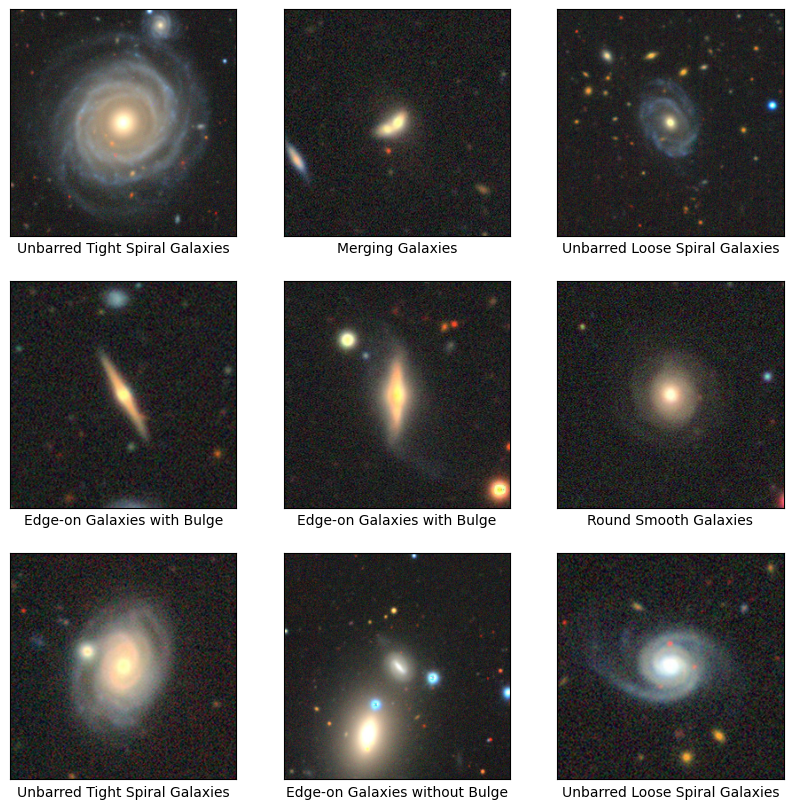

In [5]:
#显示图片及其类别
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255.)
    plt.xlabel(class_labels[int(np.argwhere(labels[i]==1))])
plt.show()

In [6]:
#SeNet的特征
class SeBlock(Model):
    def __init__(self, planes):
        super(SeBlock, self).__init__()
        self.se = Sequential()
        self.se.add(GlobalAveragePooling2D(keepdims=True))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('gelu'))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('sigmoid'))
    def call(self, inputs):
        out = self.se(inputs)
        return out

In [7]:
#ResNet的特征
class BasicBlock(Model):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(stride, stride),padding='same')) 
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.se1 = SeBlock(planes=planes)
        self.shortcut = Sequential()
        if in_planes!=planes or stride!=1:
            self.shortcut.add(Conv2D(planes,kernel_size=(1,1),strides=(stride, stride),padding='same'))
            self.shortcut.add(BatchNormalization())
        self.a2 = Activation('gelu')
    def call(self, inputs):
        out = self.basic(inputs)
        w = self.se1(out)
        out = out * w
        residual=self.shortcut(inputs)
        out = self.a2(residual+out)
        return out

In [8]:
#DlaNet的特征
class Root(Model):
    def __init__(self, planes, kernel_size=1):
        super(Root, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(kernel_size,kernel_size),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
    def call(self, inputs):
        out = concat(inputs, axis=-1)
        out = self.basic(out)
        return out

In [9]:
#DlaNet的特征
class Tree(Model):
    def __init__(self, in_planes, planes, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(planes)
            self.left_node = BasicBlock(in_planes, planes, stride=stride)
            self.right_node = BasicBlock(planes, planes, stride=1)
        else:
            self.root = Root(planes)
            self.subtrees={}
            for i in reversed(range(1, level)):
                if i==level-1:
                    subtree = Tree(in_planes, planes, level=i, stride=stride)
                else:
                    subtree = Tree(planes, planes, level=i, stride=stride)
                self.subtrees[f'level_{i}'] = subtree
            self.prev_root = BasicBlock(in_planes, planes, stride=stride)
            self.left_node = BasicBlock(planes, planes, stride=1)
            self.right_node = BasicBlock(planes, planes, stride=1)
    def call(self, inputs):
        out = inputs
        outs = [self.prev_root(out)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.subtrees[f'level_{i}']
            out = level_i(out)
            outs.append(out)
        out = self.left_node(out)
        outs.append(out)
        out = self.right_node(out)
        outs.append(out)
        out = self.root(outs)
        return out

In [10]:
#该模型没有同池化操作下采样，处理SeNet生成权值w部分，使用激活函数包括sigmoid，tanh，gelu
class CNN_net(Model):
    def __init__(self, model):
        super(CNN_net, self).__init__()
        self.stem = Sequential()
        self.stem.add(Conv2D(16,kernel_size=(5,5),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(2, 2),padding='same'))#128
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        
        self.blocks = Sequential()
        self.blocks.add(Tree(32,  64, level=2, stride=1))##128
        self.blocks.add(Tree(64,  128, level=2, stride=2))#64
        self.blocks.add(Tree(128,  256, level=2, stride=2))#32
        self.blocks.add(Tree(256,  512, level=2, stride=2))#16
        self.blocks.add(Tree(512,  1024, level=2, stride=2))#8
        self.blocks.add(Tree(1024,  2048, level=2, stride=2))#4
        self.blocks.add(Conv2D(2048,kernel_size=(4,4),strides=(1, 1),padding='valid'))#1
        self.blocks.add(BatchNormalization())
        self.blocks.add(Activation('gelu'))
        
        self.fullconnected = Sequential()
        self.fullconnected.add(Flatten())
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        
        self.out = Sequential()
        if model=='regression':
            self.out.add(Dense(1, activation='linear'))
        if model=='classification':
            self.out.add(Dense(10, activation='softmax'))
        
    def call(self, inputs):
        out = self.stem(inputs)
        out = self.blocks(out)
        out = self.fullconnected(out)
        out = self.out(out)
        return out

In [11]:
#model_classification = CNN_net(model='classification')#生成用于classification的模型
model_classification = Sequential()
model_classification.add(Conv2D(16, (3, 3), activation='relu', strides=(2, 2),padding='same'))#128
model_classification.add(MaxPooling2D((2, 2)))#64
model_classification.add(Conv2D(32, (3, 3), activation='relu', strides=(2, 2),padding='same'))#32
model_classification.add(MaxPooling2D((2, 2)))#16
model_classification.add(Conv2D(64, (3, 3), activation='relu', strides=(2, 2),padding='same'))#8
model_classification.add(MaxPooling2D((2, 2)))#4
model_classification.add(Conv2D(128, (3, 3), activation='relu', strides=(2, 2),padding='same'))#2
model_classification.add(MaxPooling2D((2, 2)))#1
model_classification.add(Flatten())
model_classification.add(Dense(64, activation='relu'))
model_classification.add(Dense(10, activation='softmax'))

In [12]:
model_classification.build(input_shape=(None, 256, 256, 3))#定义模型的input_shape
model_classification.summary()#生成模型的总结

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

In [13]:
#这里是使用SGDR的参数
#initial_learning_rate = 0.1
#first_decay_steps = 1000
#t_mul = 2.0
#m_mul = 1.0
#alpha = 0.0

In [14]:
#这里是使用SGDR编译模型
#checkpoint_save_path = r'saved_modle_classification'
#lr_reducer = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps, t_mul=2.0, m_mul=1.0, alpha=0.0)
#model_classification.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=lr_reducer,momentum=0.9,nesterov=True,weight_decay=5e-4),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())

In [15]:
#这里是使用AdamW编译模型，并用ReduceLROnPlateau调整训练中的学习率
model_classification.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=10,mode='min',min_lr=1e-20)

In [16]:
#checkpoint_save_path = 'modelsave.h5'#这里是模型的路径
#model_classification.load_weights(filepath=checkpoint_save_path)#这里是加载模型

In [17]:
train_datagen = ImageDataGenerator(
    #featurewise_center=True,#将输入数据的每个样本减去整个数据集的均值，使得数据的均值为0。这有助于使数据集的均值接近于0。
    #featurewise_std_normalization=True,#将输入数据的每个样本除以整个数据集的标准差，以使数据的标准差为1。这有助于使数据的标准差接近于1。
    rotation_range=180,#在范围内随机旋转图像，以增加数据的多样性。此参数指定旋转范围为±180度，即任意角度的旋转。
    width_shift_range=0.2,#在水平方向随机平移图像。此参数指定允许图像水平平移的范围为图像宽度的20%。
    height_shift_range=0.2,#在垂直方向随机平移图像。此参数指定允许图像垂直平移的范围为图像高度的20%。
    horizontal_flip=True,#随机水平翻转图像。这可以增加数据的多样性和泛化能力。
    rescale=1/255.,#对输入图像进行缩放，将像素值从0-255缩放到0-1范围之间。这通常是在训练之前对图像进行预处理的常见步骤。
    validation_split=0.2,#指定验证集的比例。在此情况下，20% 的数据将用作验证集，而剩余的 80% 将用于训练。
)

train_datagen.fit(images)#调用 fit 方法来计算输入图像数据的统计信息，包括均值和标准差。这将使用整个数据集来计算这些统计信息，并将它们应用于后续的数据增强和预处理过程中。

In [18]:
#mixup方法的核心
def mixup(batch_x, batch_y, alpha):
    batchs = len(batch_x)#获取一个有多少batch，这个是由train_datagen.flow()定义的
    lam = np.random.beta(alpha, alpha, size=batchs)#以beta(alpha,alpha)分布生成一个长度为batch总数的数列，其中都是大于0小于1的数

    index = np.random.permutation(batchs)#随机生成索引，大小为batch总数
    mixed_x = lam.reshape(batchs, 1, 1, 1) * batch_x + (1 - lam.reshape(batchs, 1, 1, 1)) * batch_x[index]#以index索引混合图片，按照lam对应的比例
    mixed_y = lam.reshape(batchs, 1) * batch_y + (1 - lam.reshape(batchs, 1)) * batch_y[index]#以index索引混合图片对应的标签，按照lam对应的比例

    return mixed_x, mixed_y

In [19]:
def datagen_generator(images, labels, batch_size, alpha):
    generator = train_datagen.flow(images, labels, batch_size=batch_size,subset='training')
    while True:
        batch_x, batch_y = next(generator)#next(generator) 返回的是使用 train_datagen.flow 生成器生成的下一个批次的图像数据和对应的标签。
        mixed_x, mixed_y = mixup(batch_x, batch_y, alpha)#调用mixup方法生成训练数据与标签
        yield mixed_x, mixed_y#通过使用 yield 语句返回混合后的图像数据和标签，即 yield mixed_x, mixed_y。这样，datagen_generator 函数就变成了一个生成器函数，每次调用它时，都会生成一个新的批次的混合数据。

In [20]:
batch_size = 16#batch_size大小为16
alpha = 1#alpha为1，代表着beta分布中各个概率出现的可能性相同

In [21]:
#checkpointer的作用是在训练中保存模型
#checkpointer = ModelCheckpoint(filepath=checkpoint_save_path,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
history_classification = model_classification.fit(datagen_generator(images, labels, batch_size, alpha),
                                                    validation_data=train_datagen.flow(images, labels,batch_size=batch_size, subset='validation'),
                                                    steps_per_epoch=880,#这个和batchsize挂钩，一定要添加，batchsize16下最大为886
                                                    epochs=10,
                                                    callbacks=[lr_reducer, #checkpointer
                                                              ]#调整学习率和保存模型
                                                 )


Epoch 1/10
880/880 [==============================] - 191s 216ms/step - loss: 2.2265 - categorical_accuracy: 0.1479 - val_loss: 2.2239 - val_categorical_accuracy: 0.1511 - lr: 0.0100
Epoch 2/10
880/880 [==============================] - 190s 217ms/step - loss: 2.2209 - categorical_accuracy: 0.1534 - val_loss: 2.2267 - val_categorical_accuracy: 0.1418 - lr: 0.0100
Epoch 3/10
880/880 [==============================] - 190s 216ms/step - loss: 2.2240 - categorical_accuracy: 0.1464 - val_loss: 2.2235 - val_categorical_accuracy: 0.1418 - lr: 0.0100
Epoch 4/10
880/880 [==============================] - 191s 217ms/step - loss: 2.2173 - categorical_accuracy: 0.1505 - val_loss: 2.2238 - val_categorical_accuracy: 0.1511 - lr: 0.0100
Epoch 5/10
880/880 [==============================] - 188s 213ms/step - loss: 2.2192 - categorical_accuracy: 0.1499 - val_loss: 2.2264 - val_categorical_accuracy: 0.1511 - lr: 0.0100
Epoch 6/10
880/880 [==============================] - 186s 212ms/step - loss: 2.2216 

In [22]:
print(history_classification.history)

{'loss': [2.226529359817505, 2.220860004425049, 2.22395920753479, 2.217312812805176, 2.219175100326538, 2.221637487411499, 2.2206406593322754, 2.221074342727661, 2.223961591720581, 2.2198102474212646], 'categorical_accuracy': [0.1478693187236786, 0.15344178676605225, 0.1464090347290039, 0.15052923560142517, 0.14988988637924194, 0.1419336497783661, 0.1478297859430313, 0.14633800089359283, 0.14846913516521454, 0.15031611919403076], 'val_loss': [2.223863363265991, 2.2267019748687744, 2.223466157913208, 2.2238028049468994, 2.226449728012085, 2.224778652191162, 2.2267355918884277, 2.2246463298797607, 2.223381519317627, 2.225956916809082], 'val_categorical_accuracy': [0.1511136144399643, 0.14180998504161835, 0.14180998504161835, 0.1511136144399643, 0.1511136144399643, 0.14180998504161835, 0.14180998504161835, 0.14180998504161835, 0.1511136144399643, 0.14180998504161835], 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]}


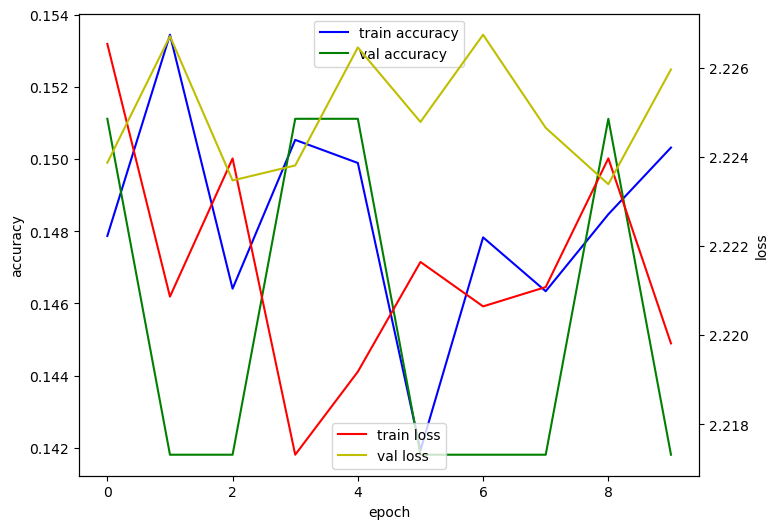

In [23]:
fig1 = plt.figure(num="model regularize", figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(history_classification.history['categorical_accuracy'], label='train accuracy', color='b')
ax1.plot(history_classification.history['val_categorical_accuracy'], label='val accuracy', color='g')
ax1.legend(loc = 'upper center')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy');
ax2 = ax1.twinx()
ax2.plot(history_classification.history['loss'], label="train loss", color='r')
ax2.plot(history_classification.history['val_loss'], label="val loss", color='y')
ax2.legend(loc=2)
ax2.set_ylabel('loss');
ax2.legend(loc = 'lower center')
plt.show()